In [165]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
#retains the same output after iteration
tf.random.set_seed(1209)

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

startDate=(2020, 1,1)
endDate=(2022, 10, 10)
 
#Get the dataset
df = pd.read_csv("SYBJF.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,3.68,3.68,3.68,3.68,0.41886,0
1,2020-01-03,3.68,3.68,3.68,3.68,0.41886,0
2,2020-01-06,3.68,3.68,3.68,3.68,0.41886,0
3,2020-01-07,3.68,3.68,3.68,3.68,0.41886,0
4,2020-01-08,3.68,3.68,3.68,3.68,0.41886,0
...,...,...,...,...,...,...,...
693,2022-10-03,1.50,1.50,1.50,1.50,1.50000,0
694,2022-10-04,1.50,1.50,1.50,1.50,1.50000,0
695,2022-10-05,1.50,1.50,1.50,1.50,1.50000,0
696,2022-10-06,1.50,1.50,1.50,1.50,1.50000,0


<AxesSubplot: xlabel='Date'>

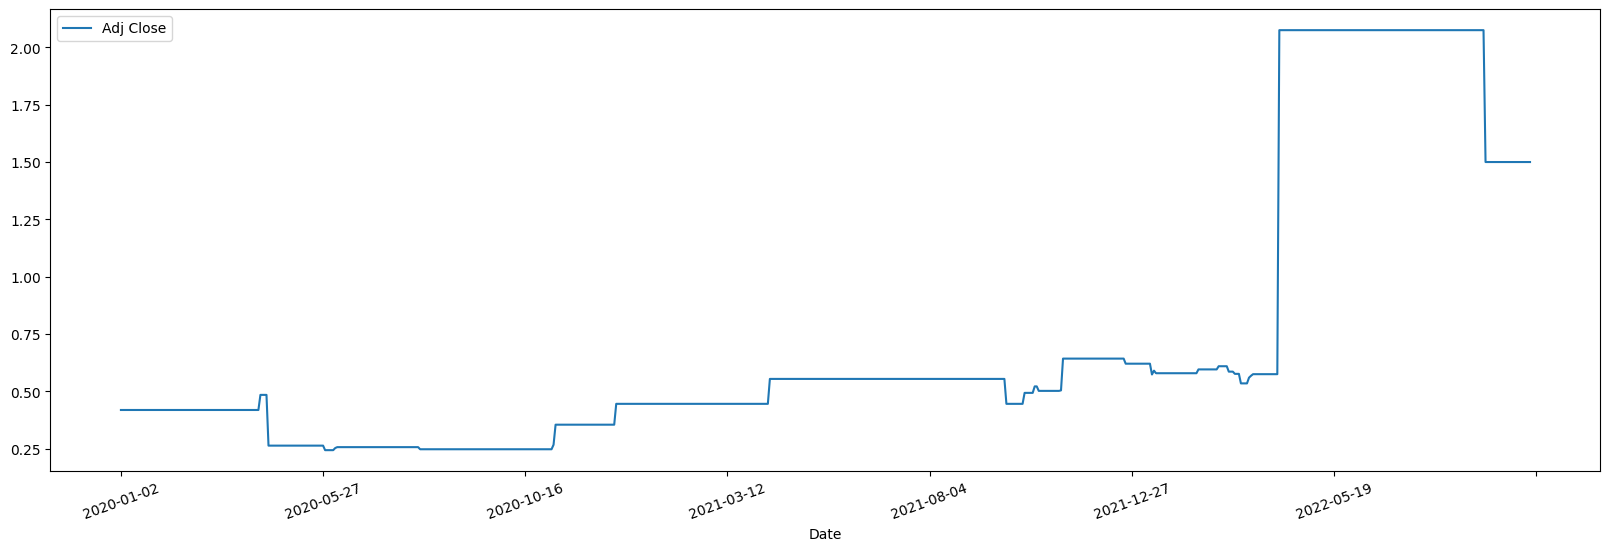

In [166]:
df['TradeDate']=df.index
 
# Plotting the stock prices
%matplotlib inline
df.plot(x='Date', y='Adj Close', kind='line', figsize=(20,6), rot=20)

In [167]:
# Extracting the closing prices of each day
FullData=df[['Close']].values
print(FullData[0:5])

# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData

print('### After Normalization ###')
X[0:5]

[[3.68]
 [3.68]
 [3.68]
 [3.68]
 [3.68]]
### After Normalization ###


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [168]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=15  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(683, 15, 1)

#### Output Data shape ####
(683, 1)


In [169]:
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(678, 15, 1)
(678, 1)

#### Testing Data shape ####
(5, 15, 1)
(5, 1)


In [170]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] -- [1.]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] -- [1.]


In [171]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 15
Number of Features: 1


In [172]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 15, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 1, epochs = 100)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
678/678 [==============================] - 8s 8ms/step - loss: 0.0339
Epoch 2/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0095
Epoch 3/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0083
Epoch 4/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0057
Epoch 5/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0056
Epoch 6/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0054
Epoch 7/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0045
Epoch 8/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0052
Epoch 9/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0046
Epoch 10/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0041
Epoch 11/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0047
Epoch 12/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0040
Epoch 13/100


678/678 [==============================] - 5s 8ms/step - loss: 0.0015
Epoch 100/100
678/678 [==============================] - 5s 8ms/step - loss: 0.0015
## Total Time Taken:  9 Minutes ##


1/1 [==============================] - 0s 400ms/step
Accuracy: 99.26188786824544


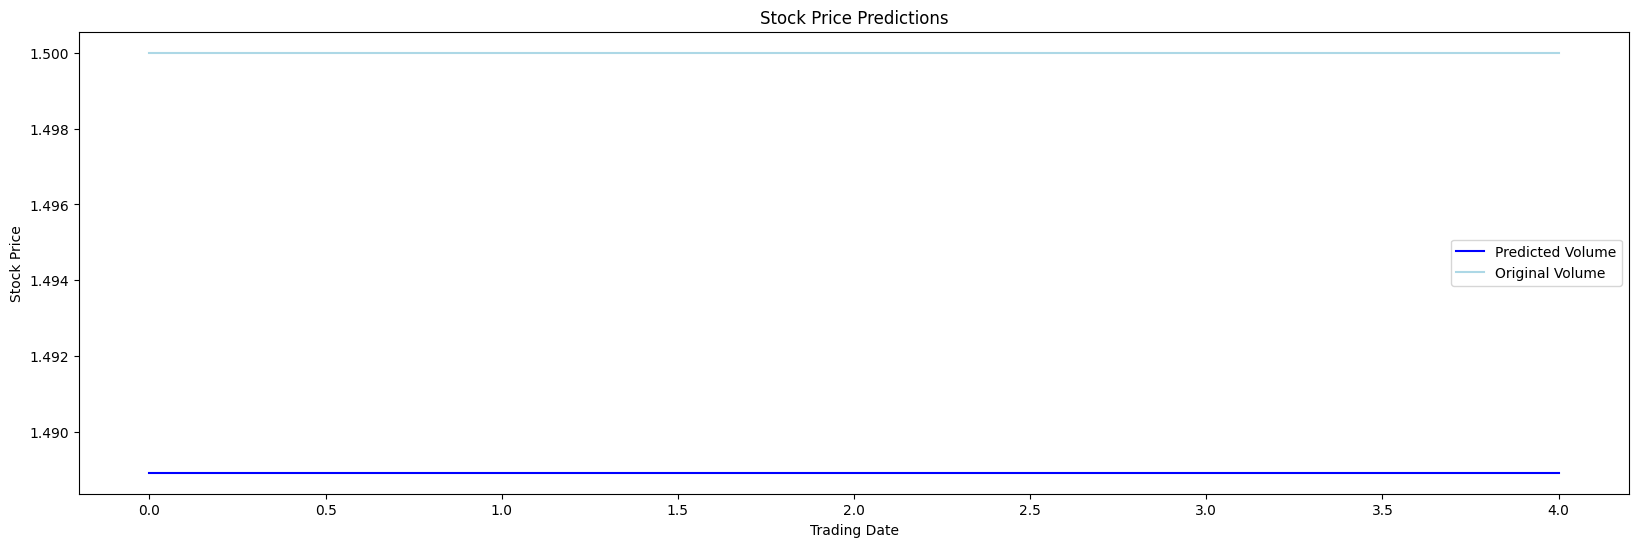

In [173]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

1/1 [==============================] - 0s 23ms/step


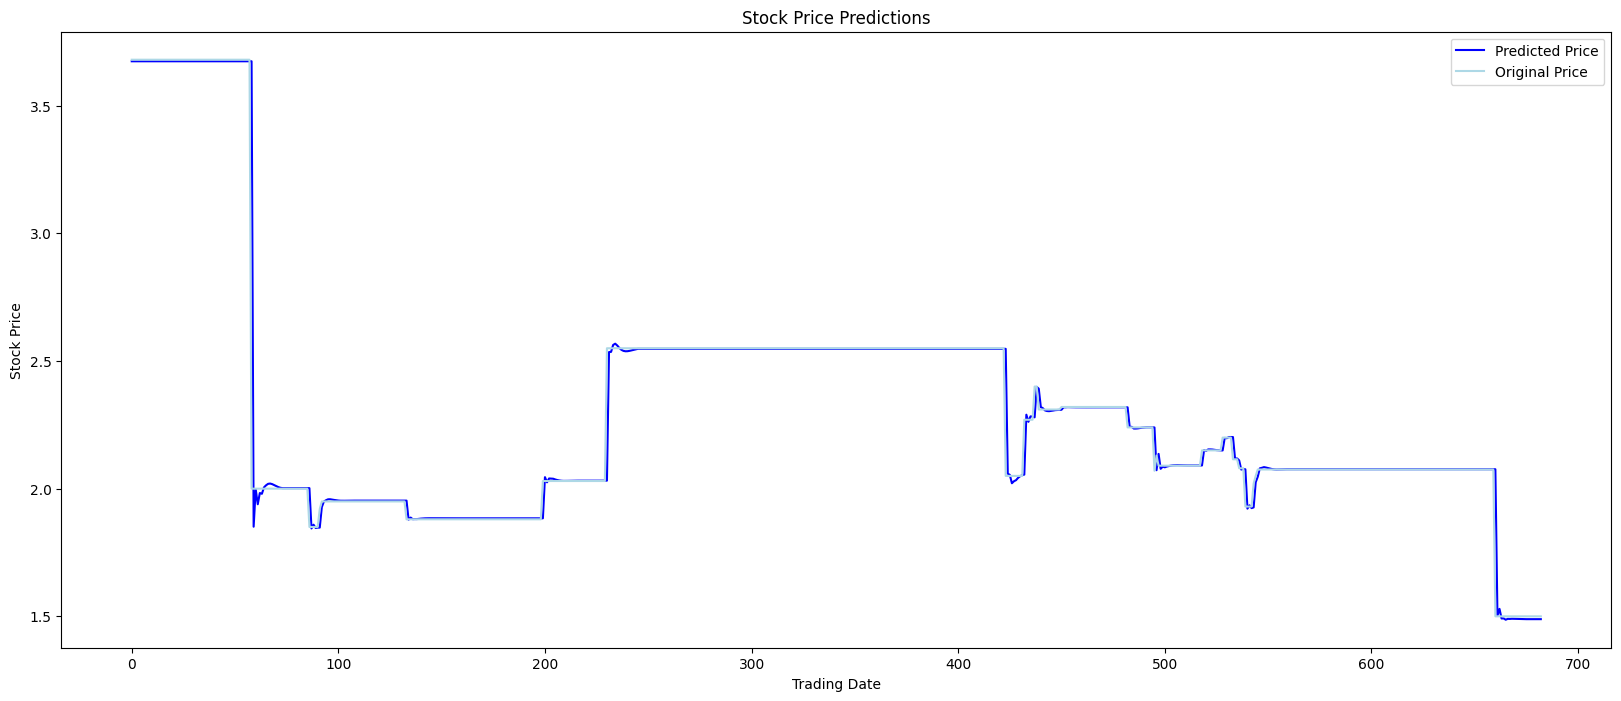

In [174]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [175]:
# Considering the Full Data again which we extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])

print('###################')

# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[1.5]
 [1.5]
 [1.5]
 [1.5]
 [1.5]
 [1.5]
 [1.5]
 [1.5]
 [1.5]
 [1.5]]
###################
Scaled Prices
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [176]:
# Multi step data preparation

# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=15  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=10 # How many days in future you want to predict the prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################

# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(673, 15, 1)
### Output Data Shape ###
(673, 10)


In [177]:
# Choosing the number of testing data records
TestingRecords=10

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)

print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(663, 15, 1)
(663, 10)

#### Testing Data shape ####
(10, 15, 1)
(10, 10)


In [178]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 15 days prices we are learning the next 10 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
====>
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
####################
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
====>
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
####################


In [179]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 15
Number of Features: 1


In [180]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 15, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

###################################################################

import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 1, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
663/663 [==============================] - 7s 8ms/step - loss: 0.0692
Epoch 2/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0172
Epoch 3/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0125
Epoch 4/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0113
Epoch 5/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0107
Epoch 6/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0101
Epoch 7/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0100
Epoch 8/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0094
Epoch 9/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0100
Epoch 10/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0091
Epoch 11/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0086
Epoch 12/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0091
Epoch 13/100


663/663 [==============================] - 5s 8ms/step - loss: 0.0064
Epoch 100/100
663/663 [==============================] - 5s 8ms/step - loss: 0.0065
############### Total Time Taken:  9 Minutes #############


In [181]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

1/1 [==============================] - 0s 389ms/step
#### Predicted Prices ####
[[1.553146  1.5628756 1.5285187 1.5554795 1.551051  1.5164719 1.5761598
  1.5435026 1.5901092 1.6040683]
 [1.5745494 1.5816662 1.54719   1.5727489 1.5742018 1.536722  1.6004225
  1.5537453 1.6010981 1.6282325]
 [1.5488435 1.5572973 1.5199673 1.5466764 1.542663  1.5047323 1.5680082
  1.5273916 1.5760089 1.5939947]
 [1.5336816 1.5427868 1.5023617 1.5310676 1.5237936 1.4845448 1.5505493
  1.5103579 1.5617609 1.576629 ]
 [1.5126901 1.5228472 1.4789768 1.5101464 1.4985973 1.4582287 1.5269384
  1.4887804 1.543307  1.5532897]
 [1.5030141 1.513485  1.4670867 1.5001208 1.4866893 1.4450144 1.5169022
  1.4773184 1.5345591 1.5439752]
 [1.4930423 1.5039456 1.4554003 1.4900049 1.4745163 1.4319091 1.5060673
  1.4663318 1.5257256 1.5335683]
 [1.4879951 1.4990727 1.4489802 1.4847223 1.4681033 1.4246807 1.5007985
  1.4601209 1.5211688 1.5287294]
 [1.4830017 1.4943212 1.4429519 1.4796302 1.461804  1.4178143 1.4952979
  1.4544

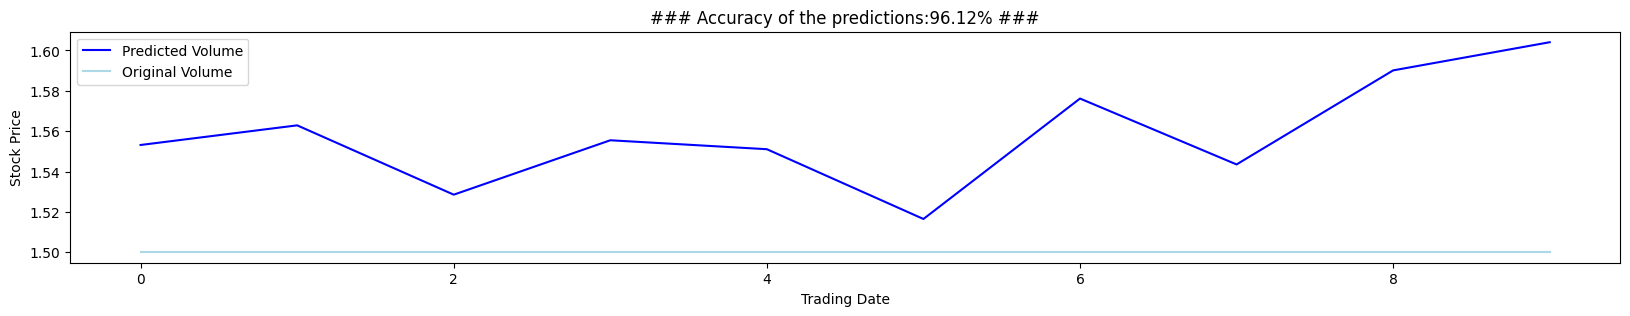

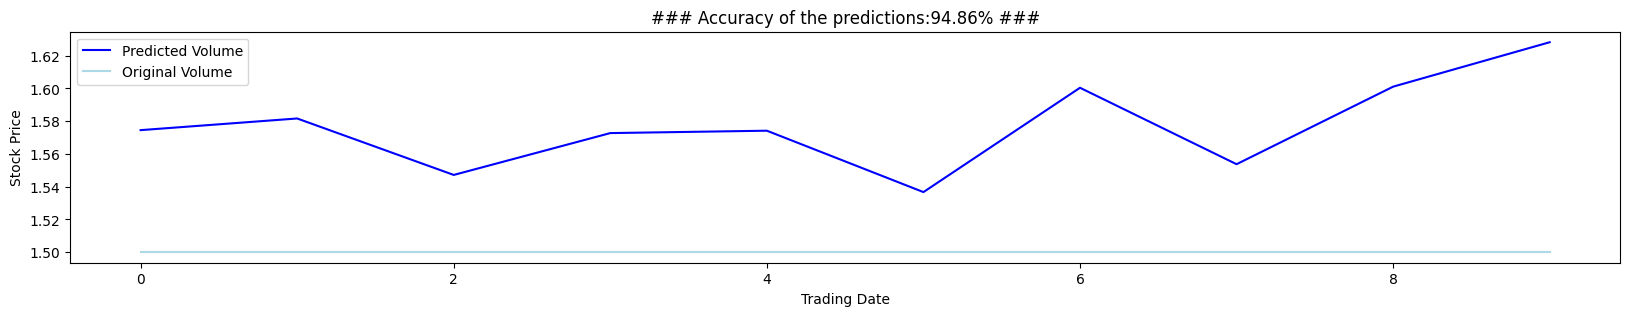

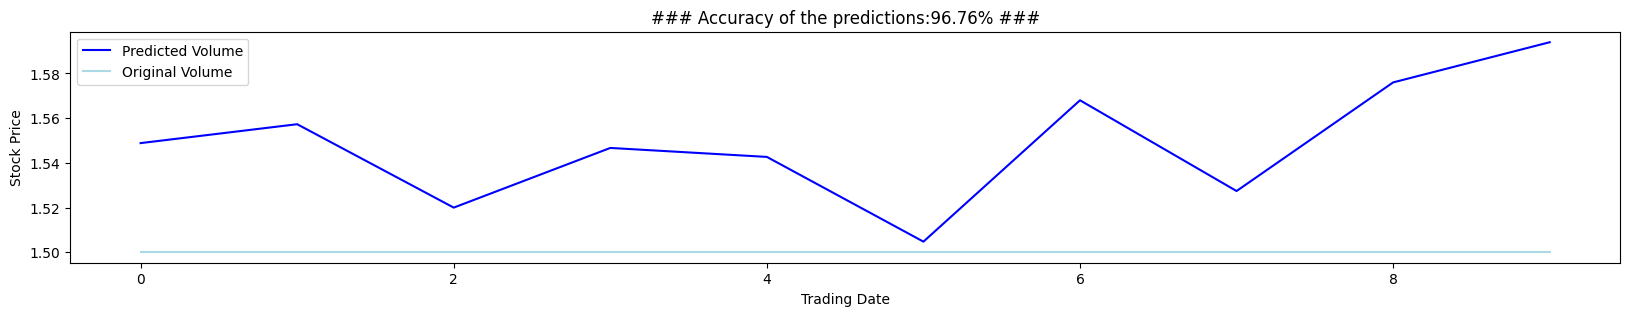

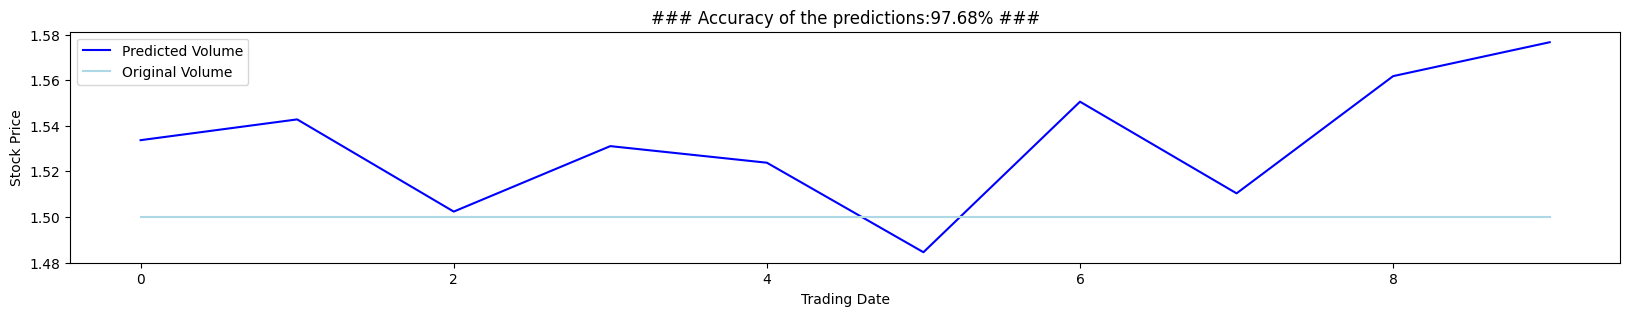

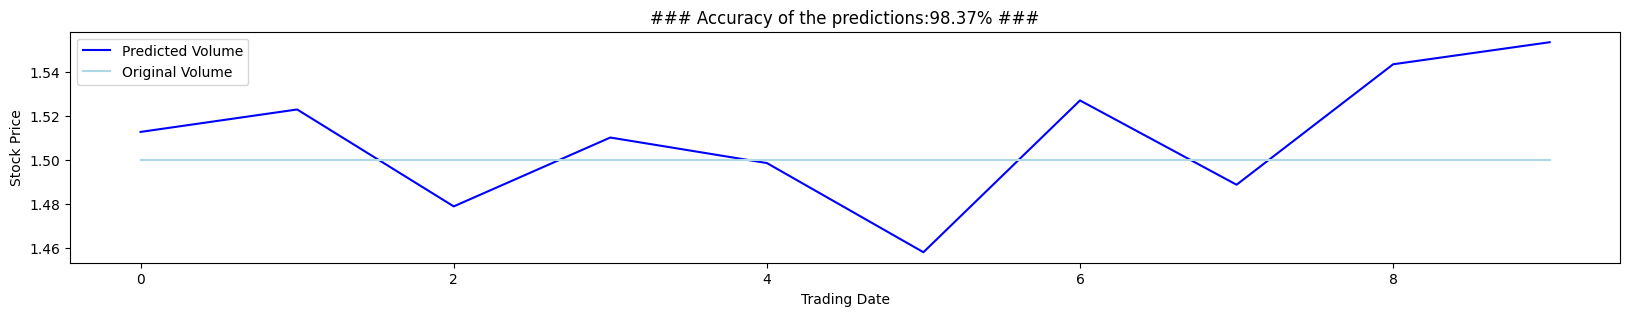

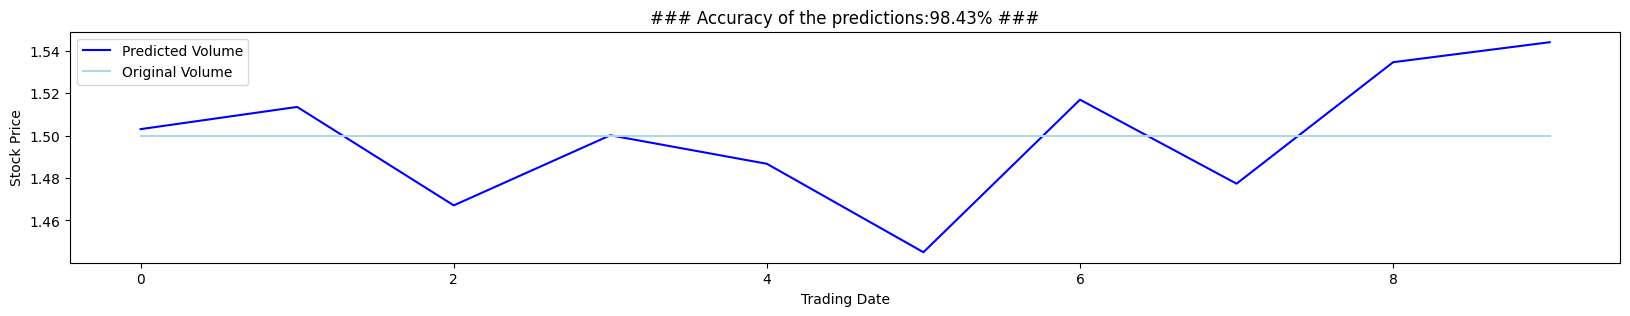

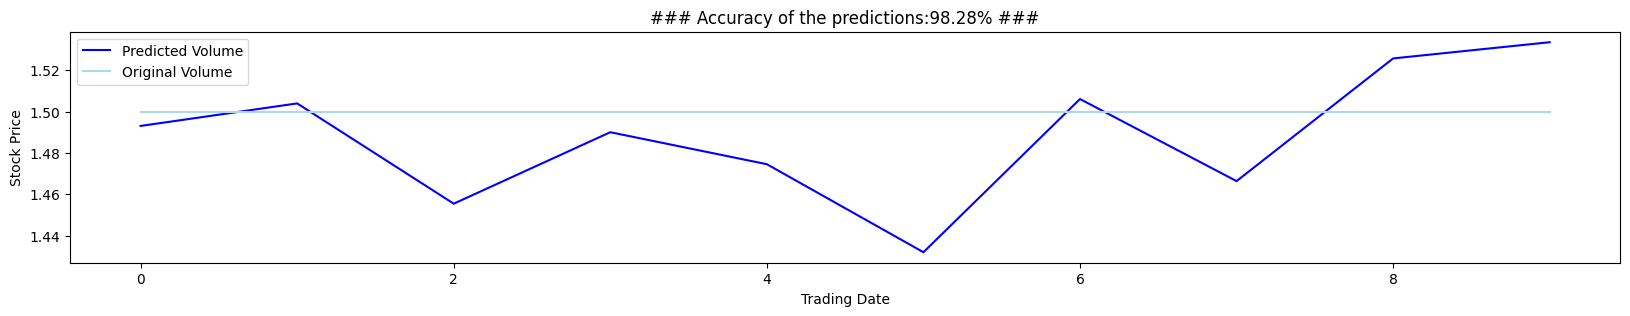

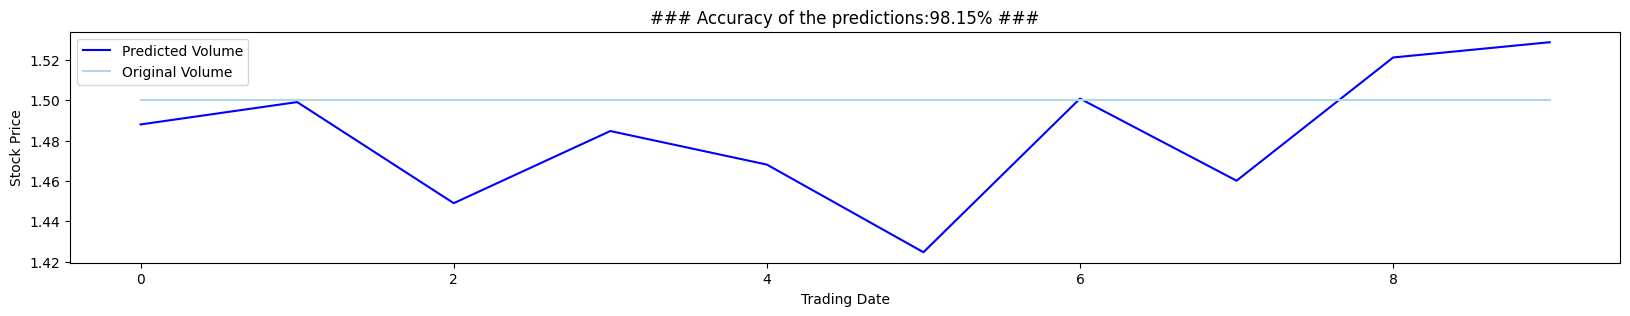

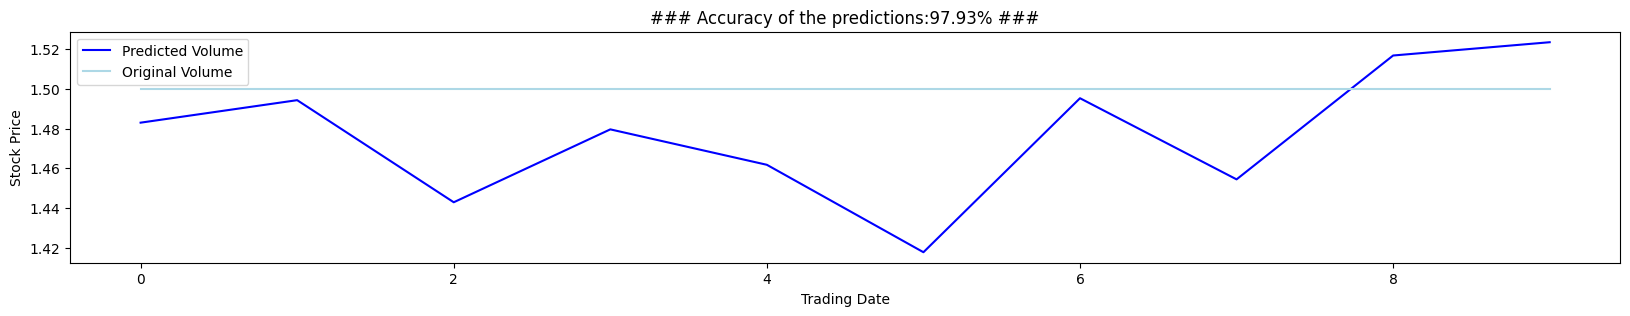

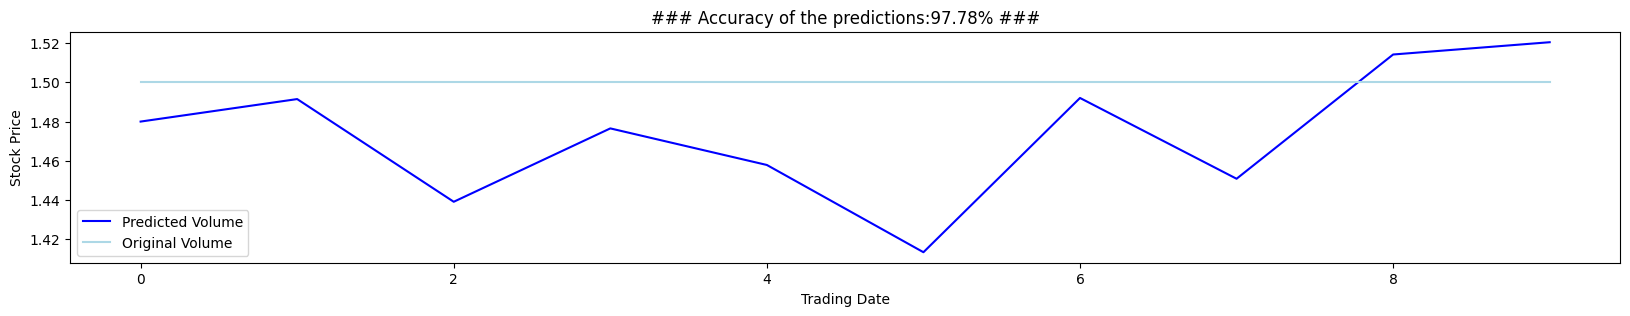

In [182]:
import matplotlib.pyplot as plt

for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')

    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps


    plt.ylabel('Stock Price')

    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

In [185]:
from numpy import array
# Making predictions on test data
Last15DaysPrices = array([1.5,1.5,1.5,1.5 ,1.5, 1.5, 1.5,1.5,1.5 ,1.5, 1.5, 1.5,1.5,1.5 ,1.5])
 
# Reshaping the data to (-1,1 )because its a single entry
Last15DaysPrices = Last15DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last15DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 7 days
Next7DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next7DaysPrice = DataScaler.inverse_transform(Next7DaysPrice)
Next7DaysPrice

1/1 [==============================] - 0s 23ms/step


array([[1.4745018, 1.4862913, 1.4322695, 1.4709178, 1.4506421, 1.4054465,
        1.4858431, 1.4445362, 1.5095268, 1.5145695]], dtype=float32)